# Machine Learning for Cryptocurrency Trading
## An Introduction

This is a brief crash course on how to use machine learning to inform cryptocurrency trading. The target audience is someone with at least some familiarity with supervised learning techniques, though not necessarily any finance or trading experience. This certainly isn't a comprehensive implementation of cutting-edge techniques, but rather a clean and logical place to start. References to more advanced strategies, especially those aimed specifically at time-series work, will be noted. Trading is definitionally zero-sum: every transaction has two sides and if one wins the other must lose. As you might imagine then, building a money making machine for a zero-sum game is awfully competitive. We'll just scratch the surface here, but it's a really fun problem to grind on because (1) the stakes are real and (2) the skillset you build doing this generalizes to a lot of meaningful problems.

**The goal here is to predict price movements and build a profitable trading strategy based on those predictions.** Data collection and trade execution vary by exchange, but are generally easy either manually or via API, so these won't be covered here. Sample data from GDAX is provided for this course. See [this repo](https://github.com/danpaquin/gdax-python) for a nice Python package for interacting with the [GDAX API](https://docs.gdax.com).

<a id='toc'></a>
### Table of Contents:
This course is broken down into 5 sections:
1. [Overview](#section1)
2. [Cleaning Raw Trading Data](#section2)
  - Transform API output to a workable dataframe
  - Take by-second data and roll it up into larger time segments for modeling at different resolutions
3. [Feature Engineering](#section3)
  - Transform the nominal values of raw data into normalized variables which can be used to build generalizable predictive models
4. [Predicting Price](#section4)
  - Train models on historical data and assess performance based on out-of-sample fit
5. Optimizing Trading Strategy
  - Given price predictions, use the return assessment framework to iterate through different trading strategies, optimizing for maximum return

The repo for this course includes a library that will perform much of the work. The code is in ```/ml_for_trading/ml4t```. This should be a useful jumping point from which you can build your own strategies.

<a id='section1'></a>

[Jump back to the TOC](#toc)
# 1. Overview
## Approach: Inference vs. Prediction
Broadly, there are two things you can do with machine learning: 
1. You can develop an understanding of how systems work. This is **inference**. The canonical example of inference is _"how does Y change as X changes?"_ Inference work is largely the domain of statistics.
2. You can make **predictions**. 

This notebook is focused almost exclusively on prediction. If you can systematically predict which way the price of a cryptocurrency is going to move, and can act efficiently to trade based on that information, you will make above-market returns. Ideally, strong inference work underpins the development of prediction systems; a logical narrative  should guide prediction modeling decisions. Here, however, (1) we're aiming for brevity and (2) there aren't really fundamentals to try to infer. Cryptocurrencies aren't _actually_ underlying any meaningful utility yet. Before there is adpotion based on utility, any pricing theory seems capricious.

## Data Sources
The models explored here will only use candlestick pricing and volume data for Bitcoin. This is about the most parsimonious set of data with which you could imagine modeling price movements. There are several other data sources you should consider if you want to push your algorithmic trading further, including:
- Other cryptocurrencies:
 - Price and volume of individual cryptocurrencies
 - Statistical relationships between assets (_e.g.,_ relative prices movements have converged and decoupled at various points)
- Deeper exchange data:
 - By-order data: candle stick data, which we're going to use here, are an aggregation of one or more orders over a set period of time. Though noticably more challenging to handle, by-order data could provide granularity that yeilds additional predictive power
 - Order book data: candle stick and by-order data record the trades that actually occured. What about orders that went unfilled? Complete orderbook data would add a lot of additonal market context. It would also add a lot more complexity: orders can be outstanding for an arbitrary amount of time and can end in three different terminal states: cancelled, partially filled, or fully filled.
- Network information: the information stored on an asset's blockchain; what's included varies by asset, but some of the common things include
 - Nodes: number and power of miners on the network
 - Transaction fees
 - Amount and velocity of transactions
 - Number and concentration of wallets
- Other exchanges: there are a lot of exchanges that have meaningful liquidity. Some may lead or lag in price movements. There may even be pure arbitrage opportunities (though you'd have to consider transaction time and fees)
- News sentiment: Reddit, Telegram, Twitter, various other chat communities, and media coverage
- Code: many open source projects save their code, and incremental updates, to public GitHub repos. Summarizing the evolution of these code bases could indicate some rough signal of quality or momentum
 - Volume and size of commits
 - Number and quality of contributors
- Non-cryptocurrency assets and macro economy indicators

## Tools:
The code in this course is exclusively Python 3.6. It relies on the popular ```numpy```, ```pandas```, and ```scikit-learn``` libraries.

<a id='section2'></a>

[Jump back to the TOC](#toc)
# Section 2: Cleaning Raw Data
Raw trading candle data were pulled from GDAX's API and saved as CSV files. In this section, these raw data are cleaned and prepared for price prediction modeling.


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Viewing options
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
# %config InlineBackend.figure_format = 'retina'   # if viewing on MBP retina and want high res plots

# ~/ml4t in this repr
import ml4t  # e.g., ml4t.TradeData()

In [2]:
REPO_PATH = %pwd
DATA_PATH = REPO_PATH + "/data/"
DATA_STARTTIME = '2017-10-01 00:00:00'
DATA_ENDTIME   = '2017-11-30 23:59:59'

In [3]:
# Create second-level index for df based on begining and end or data range
datetimes = pd.date_range(DATA_STARTTIME, DATA_ENDTIME, freq='s')
datetimes[0:10]

DatetimeIndex(['2017-10-01 00:00:00', '2017-10-01 00:00:01',
               '2017-10-01 00:00:02', '2017-10-01 00:00:03',
               '2017-10-01 00:00:04', '2017-10-01 00:00:05',
               '2017-10-01 00:00:06', '2017-10-01 00:00:07',
               '2017-10-01 00:00:08', '2017-10-01 00:00:09'],
              dtype='datetime64[ns]', freq='S')

In [4]:
# Create df with datetimes range as index
df_template = pd.DataFrame(index=datetimes)
df_template.index.name = 'dt'

In [5]:
# Import csv data

# Row names
USDBTC_COLS = ['dt'
               , 'USD-BTC_low'
               , 'USD-BTC_high'
               , 'USD-BTC_open'
               , 'USD-BTC_close'
               , 'USD-BTC_coin_vol']

# Periods of data
PERIODS = ['2017-10', '2017-11']

# USDBTC
df_USDBTC = pd.DataFrame(columns = USDBTC_COLS)

for q in PERIODS:
    df_tmp = pd.read_csv(DATA_PATH + str(q) + '_btc-usd_1sec_candles.csv', header=None)
    df_tmp.columns = USDBTC_COLS
    df_USDBTC = df_USDBTC.append(df_tmp)
del df_tmp
df_USDBTC['dt'] = pd.to_datetime(df_USDBTC['dt'], unit='s')
df_USDBTC = df_USDBTC.set_index('dt')

In [6]:
# Merge data into template df
# Using template ensures df has precise index
df = df_template.join(df_USDBTC)
df.head()

,USD-BTC_low,USD-BTC_high,USD-BTC_open,USD-BTC_close,USD-BTC_coin_vol
dt,,,,,
2017-10-01 00:00:00,4339.01,4339.01,4339.01,4339.01,0.000230
2017-10-01 00:00:01,4339.01,4339.01,4339.01,4339.01,0.069140
2017-10-01 00:00:02,4339.01,4339.01,4339.01,4339.01,0.056691
2017-10-01 00:00:03,NaN,NaN,NaN,NaN,NaN
2017-10-01 00:00:04,NaN,NaN,NaN,NaN,NaN


### Data Exploration

In [7]:
# Density of data
print('Total seconds over time series: {}'.format(df.shape[0]))

# % of seconds with trade
print('% seconds in time series with {} trades: {}'.format('USD-BTC', df['USD-BTC_low'].notna().sum()/df.shape[0]))

Total seconds over time series: 5270400
% seconds in time series with USD-BTC trades: 0.3182128491196114


In [18]:
# % of second candles with >0 volume in which high and low price are NOT the same
# Range of w/i second price variation: high / low
# Note: the more variation of price w/i a candle, the more likely the USD volume estimate will be incorrect

high_low_magnitude = (df.loc[:, 'USD-BTC_high'] / df.loc[:, 'USD-BTC_low']) - 1

print('% of USD-BTC second trade candles w/ multiple prices : {}'.format((high_low_magnitude[high_low_magnitude.notna()] != 0.0).sum() / high_low_magnitude.notna().sum()))
print('Max USD-BTC (high - low)/low : {}'.format(high_low_magnitude.max()))
print('Mean USD-BTC (high - low)/low : {}'.format(high_low_magnitude.mean()))

del high_low_magnitude

% of USD-BTC second trade candles w/ multiple prices : 0.1705625573531595
Max USD-BTC (high - low)/low : 0.0803844230876063
Mean USD-BTC (high - low)/low : 7.391075698540185e-05


31.8% of seconds have trades. Of those seconds with trades, 17.1% have multiple prices within the second. The highest w/i second difference between high and low is 8%, and the mean is 0.007%. Large variation is possible when, for instance, a big market order is placed and, in order to fulfill the volume, the market moves deep into the outstanding limit order book. 

The technique used to calculate the USD volume of a second is (open_price + close_price) / 2 * coin_volume. This should usually be quite accurate given the low variation in w/i second prices.

### Clean and Aggregate Data
ml4t.TradeData() is used to clean and aggregare the raw data. ```TradeData.clean_df_s()``` method will perform the following:
 - Fill forward missing data
  - For periods without trades, the low, high, open, and close price are set equal to the most recent closing price. Volume is set to 0.
 - USD volume is calculated as ```(open_price + close_price) / 2 * coin_volume```
 - Period return percentage is calculated as ```(close_price - open_price) / open_price```
 - Aggregations of the data are created as the following attributes of the object:
  - Minute-level: ```TradeData.df_m```
  - Hour-level: ```TradeData.df_h```
  - Day-level: ```TradeData.df_d```

Note: there may be leading NaNs in these series which can cause issues down the line. A note on how many leading NaN periods there are will be printed.

In [19]:
trade_data = ml4t.TradeData(df)
trade_data.clean_df_s()

Note: df has 0 leading NaN periods.
Second-level data have been cleaned and are accessible as .df_s
Minute, hour, and day-level data are available as .df_m, .df_h, and .df_d, respectively.


### Visualizing Data

Before building predictive models with the cleaned and formatted data, it's important to 
develop a feel for _what_ is being modeled. The ml4t library includes a couple of functions that help visualize the cleaned trade data.

For example, rolling statistics are particularly useful for modeling time series data. Below are several key variables plotted with rolling mean and standard deviations. One simple trading strategy, proposed by a man named John Bolllinger, is to buy when a price falls below the rolling mean - 2 standard deviations, and sell when it exceeds the rolling mean + 2 standard deviations. ```ml4t``` has  functions that allow much more nuanced models to be trained and tested easily, but this is a helpful heuristic to keep in mind while looking at visualizations as it has the flavor of things our models could pick up.

In [ ]:
# Daily closing price, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data.df_d, var='close', n=10, bollinger=True)

In [ ]:
# Daily USD volume, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data.df_d, var='usd_vol', n=10, bollinger=True)

This was a period of dramatic price appreciation. Recall, trading strategies will be assessed _relative_ to market performance. So, a strategy is only considered successful if it beats market performance, net of fees. 

Some initial portion of these data will be used to train models, and the end will be used as a hold-out testing set. The ml models built here will only know what they've been trained on, so they may be fragile to markedly different environments. For this reason, it's important to validate model performance on a broad set of testing data. Understanding when a model is strongly predictive and when accuracy breaks down are critical parts of building any predictive ml model.

It becomes more difficult to accurately predict prices as data are aggregated to larger periods. It's harder to predict what will happen an hour from now than it is to predict what will happen a minute from now. There's just much more that can happen in an hour than in a minute. Imagine your dog runs away. If she's been gone for an hour, you have to search a much greater area than if she's only been gone for a minute. The search radius necessary increases over time. 

The same principle applies here. However, there is a tradeoff to market prediction on increasingly small time periods: market liquidity. Simply put, if there isn't anyone to take the other size of the trade, a prediction can't be acted upon. Or, if the order book is shallow relative to the size of a market order, that order could meaningfully move the price.

One other potential problem with very small time intervals is trade execution time. For example, you may simply not be able to submit an order within a prediction window that's a small fraction of a second.

The following sections will focus on predicting minute-level data, abstracting away from liquidity and execution time concerns. (Predicting even some part of the future is a hard enough problem to start with.) Depending on the liquidity of the exchange you're trading on and the size of your orders, liquidity may be a major factor you have to consider in practice. At the minute-level, trade execution time isn't nearly as large of a concern.

To get a sense of what the data look like at the minute-levlel, see the plots below. You're encouraged to explore these data further by plotting other time intervals.

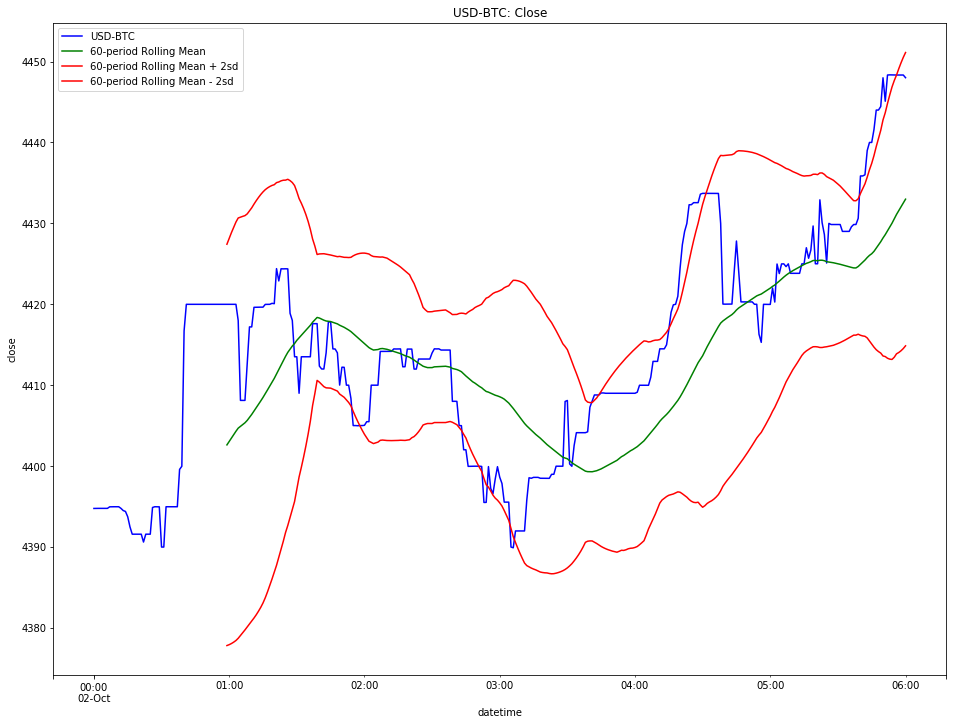

In [20]:
# Minute-level closing price, 100-minute rolling mean and Bollinger Bands
# 2017-10-01:2017-10-02
ml4t.plot_rm(trade_data.df_m['2017-10-02 00:00:00':'2017-10-02 06:00:00'], var='close', n=60, bollinger=True)

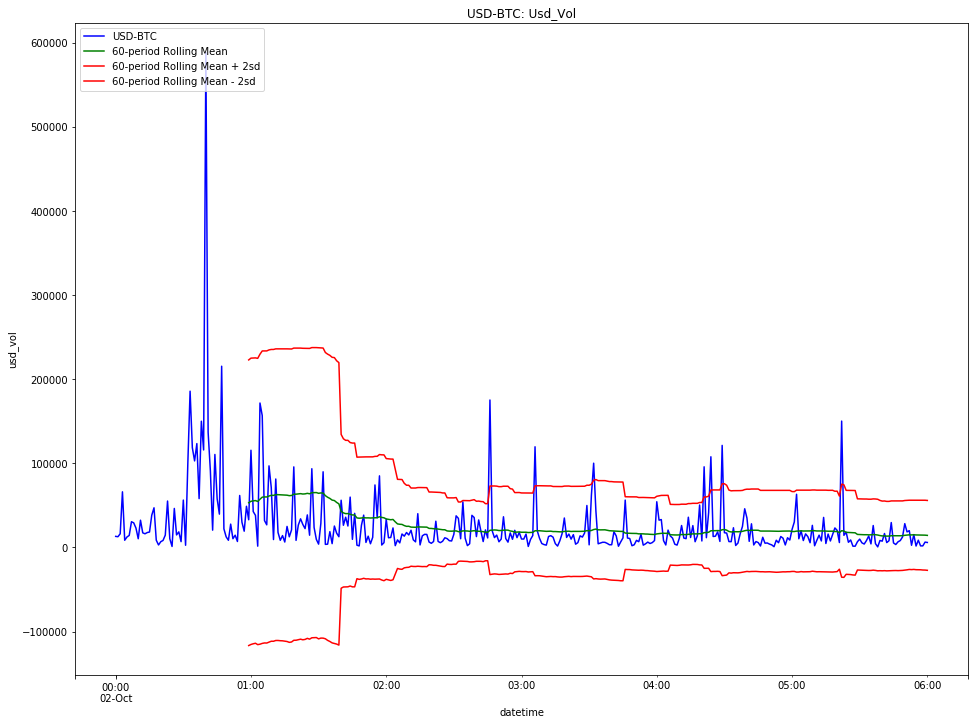

In [21]:
ml4t.plot_rm(trade_data.df_m['2017-10-02 00:00:00':'2017-10-02 06:00:00'], var='usd_vol', n=60, bollinger=True)

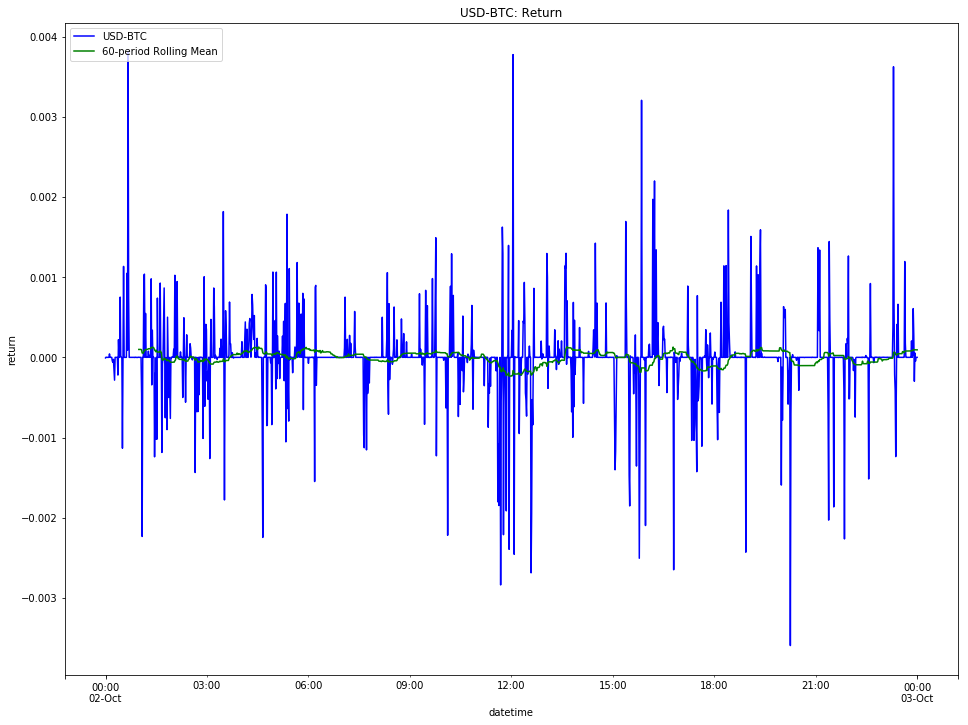

In [22]:
# For context, this is what minute-level returns looked like during a day that had a net ~0% return
ml4t.plot_rm(trade_data.df_m['2017-10-02 00:00:00':'2017-10-03 00:00:00'], var='return', n=60, bollinger=False)

<a id='section3'></a>

[Jump back to the TOC](#toc)
# Section 3: Feature Engineering
Before we attempt to build a price prediction model, we'll create potential model features.

One of the main goals of this feature engineering is to build variables that are _normalized_. This means we're adjusting the raw values to a common scale that is comparable across the time series. For example, one day the price might move from \$500 to \$1000. Another day it might move from \$10,0000 to \$10,500. Although both of these days resulted in a \$500 increase in value, the normalized changes are dramatically different: the first increased 100%, while the second only increased 5%. Percentage increase is a normalized metric and is generally more easily comparable across observations than an absolute metric. Building models based on normalized features tends to make them better at predicting the future because the measurements account for context in which they were calcualted.

Price prediction based strictly on historical price and volume is called "technical analysis" in finance. There is _a lot_ of finance literature on different metrics for this type of prediction. Here, however, we'll build just a few that have a nice intuitive feel and are closely related to common normalized statistics across domains.

- Normalized price dispersion: rolling std of closing price / rolling mean of closing price
- Price diversion from rolling mean: (period closing price - rolling mean of closing price) / rolling std of closing price; (note: Bollinger Bands are simply +2/-2 thresholds for this measurement)
- Rolling mean return
- Normalized volume dispersion: usd volume rolling std / usd volume rolling mean
- USD volume diverson from rolling mean: (period usd volume - rolling mean of usd volume) / rolling std of usd volume
- Boolean for if return is positive
- \# of periods in which return has maintained positive return
- \# of periods in which return has maintained negative return (we won't be including interaction terms in our models, so we want both the negative and positive version of this metric)

In [23]:
ml4t.calc_static_features(trade_data.df_m)

,USD-BTC_return_lag1,USD-BTC_return_pos_momentum,USD-BTC_return_neg_momentum,USD-BTC_return_pos
dt,,,,
2017-10-01 00:00:00,NaN,0,0,True
2017-10-01 00:01:00,5.531216e-05,1,0,True
2017-10-01 00:02:00,1.474909e-04,0,0,False
2017-10-01 00:03:00,-2.304206e-06,0,0,True
2017-10-01 00:04:00,4.608433e-06,1,0,True
2017-10-01 00:05:00,2.304206e-05,2,0,True
2017-10-01 00:06:00,2.327194e-04,3,0,True
2017-10-01 00:07:00,2.303617e-04,4,0,True
2017-10-01 00:08:00,2.049747e-04,5,0,True


In [ ]:
trade_data.df_m.head()

In [ ]:
ml4t.calc_rolling_features(trade_data.df_m, 10)

Still have to deal with missing obs up front, but looking good!

<a id='section4'></a>

[Jump back to the TOC](#toc)
# 4. Predicting Price
This section features several attempts to predict future prices based on historical data. The high-level modeling strategy is as follows:

### Binary Dependent Variable
Here price prediction is approached as a binary output: will price in the future be higher, or not? (The regression-approach alternative to this is predicting future return percentage.) A binary dependent variable has the advantage of being easily interpreted as a percentage of likelihood. 

### Measure of Accuracy
The accuracy of a model will be assessed as the percentage of higher/ not higher price predictions it correctly identifies in a hold-out test set. A model is useful to the degree it's predictions exceed the baseline of predicting the % of test periods with price increases is the same as the % of training periods with price increases. 

(Note: to the degree the training data differs from an equal 50-50 split among outcome labels, the models trained on these data can be biased. In a future iteration of this course, and in your own work, training data should be balanced before specifying models.)

In the next section, predicted odds of future period price increase will be used to build a trading strategy. Simple optimization of net-of-fee returns based threshold will determine the final trading strategy (e.g., "buy if predicted odds of price increase is >=X%").

### Considering Fees
Initially, the price prediction models will ignore trading fees and focus strictly on predicting price increase/ or not. One potential extension of this approach is predicting not just the odds of a price increase, but a price increase _net of fees_. 

Although these price prediction models won't be considering fees explicitly, they should still be directionally accurate: a higher the likelihood of any price increase implies a higher likelihood of a price increase that exceeds trading fees. Again, however, this is another wrinkle to consider in future extensions of a full algorithmic trading system.

## Decision Trees/ Random Forest
The first models used to predict prices are decision trees. Both an information gain driven implementation and a random (forest) driven implementation will be used. 

Pros:
- DTs are non-parametric. Given 

Cons:
- DTs tend to overfit on models with a large number of features

Warnings:
- Decision trees are biased if one class out outcome dominates the training data. To avoid this bias, consider rebalancing training data ensure as many training examples result in increases as decreases.

### Model Decisions to Test:
- Leaf size: \[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30\]
- Bags: \[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\]
- Boosting: 0/1
- Lagged periods to include: 1, 5, 10, 20, 30, 60
- Entropy information gain/ random: 0/1

predict 1 min from now; 60 min from now
